In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Constant import Constant
from Moment import Moment
from Team import Team
from Game import Game
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle, Rectangle, Arc
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import copy

In [196]:
from collections import defaultdict
import os

In [ ]:
import torch

In [3]:
game = Game('data/0021500001.json')
game.read_json()

loading  472


In [4]:
df = pd.read_json('data/0021500001.json')

In [5]:
class MyGame():
    def __init__(self, path):
        pass

In [6]:
print(f"Total events: {len(df)}")
print(f"Total moments: {np.sum([len(df['events'][i]['moments']) for i in range(len(df['events']))])}")
# print(f"moments/event: {[len(df['events'][i]['moments']) for i in range(len(df['events']))]}")

Total events: 472
Total moments: 222856


In [193]:

def add_game(games, teams, players, game_data):
    home = game_data['events'][0]['home']
    visitor = game_data['events'][0]['visitor']
    gameid = game_data['gameid'][0]
    add_team(teams, players, home)
    add_team(teams, players, visitor)
    game_data = {'id': gameid, 'ohid': len(games), 'id_home': home['teamid'], 'id_visitor': visitor['teamid']}
    games[gameid] = game_data
    
def add_team(teams, players, team_data):
    team_data = copy.copy(team_data)
    team_data['id'] = team_data['teamid']
    team_data['ohid'] = len(teams)
    
    for player_data in team_data['players']:
        add_player(players, player_data, team_data['id'])
        
    team_data['id_players'] = [player['playerid'] for player in team_data['players']]
    del team_data['players'], team_data['teamid']
    teams[team_data['id']] = team_data

def add_player(players, player_data, id_team):
    player_data = copy.copy(player_data)
    player_data['id'] = player_data['playerid']
    player_data['ohid'] = len(players)
    player_data['id_team'] = id_team
    del player_data['playerid']
    
    if player_data['id'] in players and player_data['id_team'] != players[player_data['id']]['id_team']:
        raise Exception('Duplicate Player on different team!')
        
    players[player_data['id']] = player_data



In [195]:
dir_data = 'data_small'
games = {}
teams = {}
players = {}
for path in tqdm([dir_data+'/'+file for file in os.listdir(dir_data) if file.endswith('.json')]):
    df = pd.read_json(path)
    add_game(games, teams, players, df)

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
a[0]

[1,
 1445991110020,
 720.0,
 24.0,
 None,
 [[-1, -1, 47.25031, 26.14806, 6.76567],
  [1610612737, 2594, 45.70423, 15.5787, 0.0],
  [1610612737, 200794, 56.87016, 22.95879, 0.0],
  [1610612737, 201143, 47.26914, 24.47616, 0.0],
  [1610612737, 201952, 28.26728, 23.734, 0.0],
  [1610612737, 203145, 40.59368, 31.74141, 0.0],
  [1610612765, 101141, 56.27694, 25.5146, 0.0],
  [1610612765, 202704, 73.64107, 25.48774, 0.0],
  [1610612765, 202694, 48.64923, 35.26915, 0.0],
  [1610612765, 203484, 48.46352, 14.55436, 0.0],
  [1610612765, 203083, 47.51449, 24.36448, 0.0]]]

In [137]:
def fill_nan(data, shape=None, dtype=np.float32):
    ans = np.full(shape, fill_value=np.nan, dtype=dtype)
    for i, di in enumerate(data):
        ans[i, :len(di), ...] = di
    return ans

def get_data(df):
    data = defaultdict(lambda : [])
    
    propers = []
    for event in tqdm(df['events']):
        moments = event['moments']
        if len(moments)==0:
            continue
        
        # for moment in moments:
            # quarter, _, t_game, t_shot, _, player_data = moment
        
        data['quarter'].append(np.array([ai[0] for ai in moments]))
        data['t_game'].append(np.array([ai[2] for ai in moments]))
        data['t_shot'].append(np.array([ai[3] for ai in moments]))
        
        data['id_team'].append(fill_nan([[aii[0] for aii in ai[5]] for ai in moments],
                                        shape=(len(moments), 11), dtype=np.int64))
        data['id_player'].append(fill_nan([[aii[1] for aii in ai[5]] for ai in moments],
                                          shape=(len(moments), 11), dtype=np.int64))
        data['x'].append(fill_nan([[aii[2:] for aii in ai[5]] for ai in moments],
                                  shape=(len(moments), 11, 3)))
    return data



In [145]:
for path in tqdm(os.listdir('data')):
    if not path.endswith('.json'):
        continue
        
    df = pd.read_json('data/'+path)

    data = get_data(df)
    event_mask = np.array([np.isnan(a).any() for a in data['x']])
    event_lengths = np.array([a.shape[0] for a in data['x']])

    print('Dropping events: ')
    print(f'{event_mask.sum()}/{len(event_mask)} = {event_mask.sum()/len(event_mask):0.03f}')
    print('Dropping moments: ')
    print(f'{event_lengths[event_mask].sum()}/{event_lengths.sum()} = {event_lengths[event_mask].sum()/event_lengths.sum():0.03f}')
    print()



  0%|          | 0/1269 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

Dropping events: 
77/460 = 0.167
Dropping moments: 
41653/220422 = 0.189



  0%|          | 0/451 [00:00<?, ?it/s]

Dropping events: 
52/436 = 0.119
Dropping moments: 
22823/197949 = 0.115



  0%|          | 0/489 [00:00<?, ?it/s]

Dropping events: 
41/489 = 0.084
Dropping moments: 
19865/229746 = 0.086



  0%|          | 0/425 [00:00<?, ?it/s]

Dropping events: 
33/360 = 0.092
Dropping moments: 
20968/189060 = 0.111



  0%|          | 0/432 [00:00<?, ?it/s]

Dropping events: 
45/427 = 0.105
Dropping moments: 
23545/210094 = 0.112



  0%|          | 0/418 [00:00<?, ?it/s]

Dropping events: 
31/376 = 0.082
Dropping moments: 
14394/173861 = 0.083



  0%|          | 0/466 [00:00<?, ?it/s]

Dropping events: 
54/466 = 0.116
Dropping moments: 
23569/219929 = 0.107



  0%|          | 0/428 [00:00<?, ?it/s]

Dropping events: 
29/403 = 0.072
Dropping moments: 
14084/183861 = 0.077



  0%|          | 0/467 [00:00<?, ?it/s]

Dropping events: 
31/394 = 0.079
Dropping moments: 
12656/170942 = 0.074



  0%|          | 0/531 [00:00<?, ?it/s]

Dropping events: 
103/518 = 0.199
Dropping moments: 
49130/234904 = 0.209



  0%|          | 0/481 [00:00<?, ?it/s]

Dropping events: 
138/478 = 0.289
Dropping moments: 
87495/253911 = 0.345



  0%|          | 0/497 [00:00<?, ?it/s]

Dropping events: 
93/486 = 0.191
Dropping moments: 
45626/205808 = 0.222



  0%|          | 0/419 [00:00<?, ?it/s]

Dropping events: 
128/391 = 0.327
Dropping moments: 
65365/188624 = 0.347



  0%|          | 0/445 [00:00<?, ?it/s]

Dropping events: 
82/441 = 0.186
Dropping moments: 
62588/247331 = 0.253



  0%|          | 0/438 [00:00<?, ?it/s]

Dropping events: 
76/422 = 0.180
Dropping moments: 
41077/209767 = 0.196



  0%|          | 0/466 [00:00<?, ?it/s]

Dropping events: 
62/460 = 0.135
Dropping moments: 
33454/209694 = 0.160



  0%|          | 0/500 [00:00<?, ?it/s]

Dropping events: 
47/472 = 0.100
Dropping moments: 
23174/222594 = 0.104



  0%|          | 0/443 [00:00<?, ?it/s]

Dropping events: 
49/422 = 0.116
Dropping moments: 
30625/214522 = 0.143



  0%|          | 0/473 [00:00<?, ?it/s]

Dropping events: 
50/463 = 0.108
Dropping moments: 
27196/210216 = 0.129



  0%|          | 0/462 [00:00<?, ?it/s]

Dropping events: 
38/456 = 0.083
Dropping moments: 
22634/228097 = 0.099



  0%|          | 0/473 [00:00<?, ?it/s]

Dropping events: 
26/395 = 0.066
Dropping moments: 
13326/164192 = 0.081



  0%|          | 0/444 [00:00<?, ?it/s]

Dropping events: 
31/411 = 0.075
Dropping moments: 
17423/200177 = 0.087



  0%|          | 0/454 [00:00<?, ?it/s]

Dropping events: 
84/453 = 0.185
Dropping moments: 
53575/238397 = 0.225



  0%|          | 0/482 [00:00<?, ?it/s]

Dropping events: 
85/427 = 0.199
Dropping moments: 
43868/185729 = 0.236



  0%|          | 0/485 [00:00<?, ?it/s]

Dropping events: 
107/484 = 0.221
Dropping moments: 
51995/214040 = 0.243



  0%|          | 0/451 [00:00<?, ?it/s]

Dropping events: 
58/419 = 0.138
Dropping moments: 
30203/183479 = 0.165



  0%|          | 0/451 [00:00<?, ?it/s]

Dropping events: 
103/449 = 0.229
Dropping moments: 
52932/220018 = 0.241



  0%|          | 0/443 [00:00<?, ?it/s]

Dropping events: 
43/343 = 0.125
Dropping moments: 
26065/165626 = 0.157



  0%|          | 0/506 [00:00<?, ?it/s]

Dropping events: 
90/496 = 0.181
Dropping moments: 
51266/227133 = 0.226



  0%|          | 0/476 [00:00<?, ?it/s]

Dropping events: 
41/403 = 0.102
Dropping moments: 
22485/192858 = 0.117



  0%|          | 0/483 [00:00<?, ?it/s]

Dropping events: 
68/457 = 0.149
Dropping moments: 
32829/213951 = 0.153



  0%|          | 0/432 [00:00<?, ?it/s]

Dropping events: 
59/421 = 0.140
Dropping moments: 
31147/181675 = 0.171



KeyboardInterrupt: 

In [148]:
np.mean([len(event) for event in data['x']])

431.53206650831356

In [85]:
print('events: ')
print(f'{data.sum()}/{len(data)} = {data.sum()/len(data): .02f}   (missing {len(data)-data.sum()}/{len(data)})')

423/472 =  0.90   (missing 49/472)


In [ ]:
x = np.array(x)
x = torch.from_numpy(x)

In [ ]:
npx.shape

(120, 11, 3)

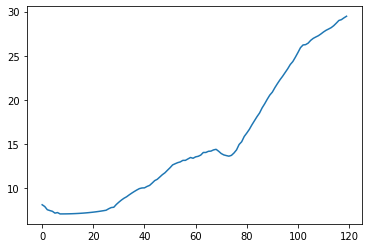

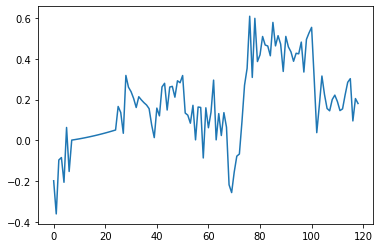

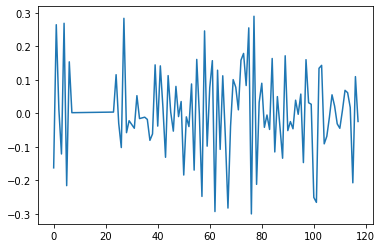

In [ ]:
plt.plot(x[:, 0, 0])
plt.show()
plt.plot(x.diff(dim=0)[:, 0, 0])
plt.show()
plt.plot(x.diff(dim=0).diff(dim=0)[:, 0, 0])
plt.show()